# **Práctica Final Parte 2:** 

## Autores:
- *Blanca Bueno*
- *Guillermo Navarro*

En esta segunda parte nos centramos en contestar a las tres primeras preguntas que se plantean. Además de hacer un análisis previo de valores que consideramos interesantes. 


In [1]:
# Importamos librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import sklearn
random_state = 100
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Conectamos el notebook a google drive donde se encuentran los datos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
Datos_Train=pd.read_csv('/content/drive/MyDrive/Datos_train.csv')
Datos_Test=pd.read_csv('/content/drive/MyDrive/Datos_test.csv')

y_pd_loan=Datos_Train['objetivo']
y_pd_loan_test=Datos_Test['objetivo']
X_pd_loan=Datos_Train.drop('objetivo',axis=1)
X_pd_loan_test=Datos_Test.drop('objetivo',axis=1)

## **Análisis exploratorio** 

### **Análisis exploratorio inicial**

Calcularemos la correlación de las variables para comprobar si existe redundacia entre variables y debemos suprimir alguna de ellas de cara a evitar problemas en la aplicación de los modelos.

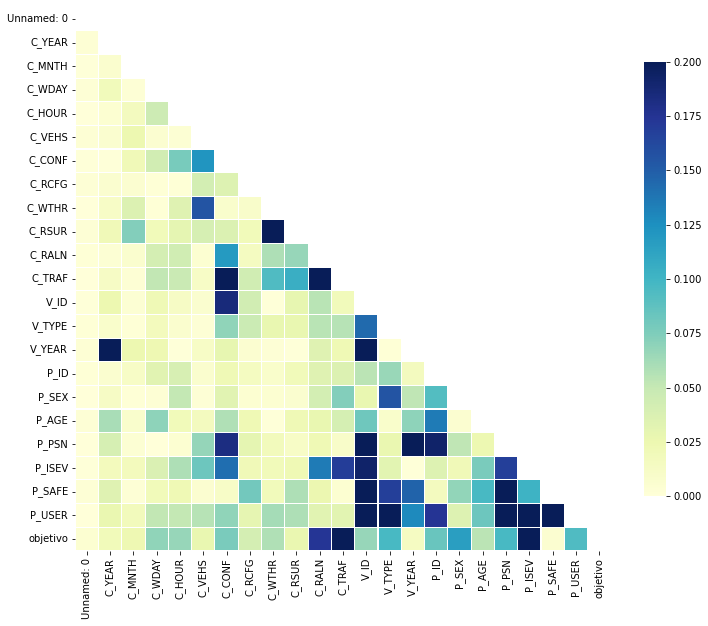

In [4]:
corr = np.abs(Datos_Train.corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask,vmin = 0.0, vmax=0.2, center=0.1,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

Las variables, como puede comprobarse, apenas guardan correlación entre si, siendo la máxima de 0.20. Por consiguiente mantendremos la totalidad de los datos, ya que si aplicasemos un algortimo de reducción dimensionales, lo más probable es que se mantuviese el número de variables.

Añadiremos una nueva variable al dataframe donde aparecerá la fecha completa de los accidentes registrados. Esta se hará con la unión de las variables indicativas del dia, mes, año y hora del mismo.

In [5]:
import datetime
day='C_WDAY'
month='C_MNTH'
year='C_YEAR'
hora= 'C_HOUR'
fechas = X_pd_loan[year].astype(int).astype(str) + "-" + X_pd_loan[month].astype(int).astype(str) 
Datos_Train['Date']=pd.to_datetime(fechas)

In [6]:
# Creamos una variable de valor 1 para poder contar los valores al hacer el groupby()
z=[]
d=1
for i in range(len(Datos_Train)):
  z.append(d)

Datos_Train['objetivo_count']=z
w=Datos_Train.groupby(['objetivo','Date']).sum()
w=w.reset_index()

En los gráficos siguientes veremos la evolución de la variable objetivo, es decir, de los accidentes con víctimas mortales y los que no producen heridos de gravedad, a lo largo de los años, meses, semanas y horas:

In [7]:
# Gráfico de accidentes graves y leve en función de la fecha en la que tuvieron lugar
import plotly.express as px
import plotly.graph_objects as go
dfg = w
fig = px.line(dfg, x='Date', y="objetivo_count",color=dfg["objetivo"].astype(str))
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.show()


Podemos ver como a lo largo de los años el número de accidentes (de ambos tipos) reduce de forma progresiva. A lo largo de estos años se han sucedido una serie de regulaciones sobre el sistema de puntos de la licencia de conducir en canadá (demerit point system) que ha favorecido esta reducción de accidentes. La ley vigente actualmente es de julio de 2021 (datos que no aparecen en el dataset estudiado).

En cuanto a la evolución mensual:

In [8]:
# Número de accidetes en función del mes
w=Datos_Train.groupby(['objetivo',month]).sum()
w=w.reset_index()
fig = px.line(w, x=month, y="objetivo_count",color=w["objetivo"].astype(str))
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.show()

Puede comprobarse que los accidentes ocurren mayoritariamente en la segunda mitad del año, especialmente durante los meses de verano, lo que puede deberse a que coincide con la época en la que ocurren mayores desplazamientos. De nuevo, la evolución es similar para las dos categorías de accidente.

Canadá durante los primeros meses del año se caracteriza por fuertes nevadas, que imposibilitan en muchos casos el uso de transportes, reduciendo en consecuencia el número de accidentes en estos meses.

Observemos la progresión según el dia de la semana:

In [9]:
# Número de accidentes por día de la semana.
w=Datos_Train.groupby(['objetivo',day]).sum()
w=w.reset_index()
fig = px.line(w, x=day, y="objetivo_count",color=w["objetivo"].astype(str))
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.show()

Observamos como en ambos casos la mayoría suceden durante los viernes y sábados, ocurriendo la mayor parte de los accidentes graves este último dia. Puede entenderse que durante la semana, para ir al trabajo, o universidad se utilicen otros medios de transporte alternativos que no aparezcan en la lista (por ejemplo metro).

Comprobamos a continuación las horas de los mismos:

In [10]:
# Gráfico de número de accidentes en función de la hora.
w=Datos_Train.groupby(['objetivo',hora]).sum()
w=w.reset_index()
fig = px.line(w, x=hora, y="objetivo_count",color=w["objetivo"].astype(str))
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()

La mayor parte de los accidentes de ambas clases ocurren a las 16h. Hora de salida del trabajo en el país estudiado. Otras posibles causas podrían ser cansancio, almuerzos pesados donde se ha podido beber, mayor densidad de tráfico...

### **Pregunta 1** 
**¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son más propensos a tener accidentes (acción correctiva en prima)?**

Estudiaremos  a continuación diversas variables que han podido influir en la mayor cantidad de accidentes, tanto a nivel de las características del vehículo, de los involucrados y las condiciones climáticas.

In [11]:
newnames = {'1':'Light Duty Vehicle', 
            '5': 'Panel/cargo van',
            '6':'Other trucks and vans',
            '7':'Unit trucks > 4536 KG',
            '8':'Road tractor',
            '9':'School bus',
            '10':'Smaller school bus', 
            '11': 'Urban and Intercity Bus',
            '14':'Motorcycle and moped',
            '16':'Off road vehicles ',
            '17':'Bicycle',
            '18':'Purpose-built motorhome',
            '19':'Farm equipment',
            '20':'Construction equipment',
            '21':'Fire engine',
            '22':'Snowmobile',
            '23':'Street car'}

Comprobaremos en primer lugar la proporción de accidentes graves y leves en función de la tipología de vehículo:

In [25]:
w=Datos_Train.groupby(['objetivo','V_TYPE']).sum()
w=w.reset_index()
graves=w.loc[w['objetivo'] == 1]
graves=graves.sort_values('objetivo_count', ascending=False).head(5)
leves=w.loc[w['objetivo'] == 0]
leves=leves.sort_values('objetivo_count', ascending=False).head(5)

fig = px.bar(w, x='V_TYPE', y='objetivo_count', color=w["objetivo"].astype(str), title='Cantidad de accidentes en función del la tipología del coche')
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()

fig = px.bar(graves, x='V_TYPE', y='objetivo_count', title='Top 5 de cantidad de accidentes graves en función del la tipología del coche')

fig.show()

fig = px.bar(leves, x='V_TYPE', y='objetivo_count', title='Top 5 de cantidad de accidentes leves en función del la tipología del coche')

fig.show()

Podemos ver como, respecto del tipo de vehículo, tanto en el caso de accidentes graves como leves, existe una tipología claramente más propensa a sufrir colisiones. Estos, el tipo 1, son los vehículos ligeros (coches y furgonetas de pasajeros, vehículos utilitarios y camionetas ligeras). El resto incluyen, entre otros, transporte de mercancias, camiones de unidades pesadas, autobuses escolares... que requieren de un conductor especialmente cualificado y profesional, con menor riesgo a sufrir accidentes. 

Analizaremos de este tipo de vehículos cuales son más propensos a sufrir colisiones atendiendo al año de matriculación, es decir, el año en el que se compra y entra en funcionamiento el mismo, pudiendo influir esto en la propensión a sufrir accidentes, debido a, por ejemplo, problemas con los modelos o marcas más vendidas.

In [13]:
w=Datos_Train.loc[Datos_Train['V_TYPE'] == 1]
w=w.groupby(['objetivo','V_YEAR']).sum()
w=w.reset_index()
w=w.loc[w['V_YEAR'] > 1960]

graves=w.loc[w['objetivo'] == 1]
graves=graves.sort_values('objetivo_count', ascending=False).head(10)
leves=w.loc[w['objetivo'] == 0]
leves=leves.sort_values('objetivo_count', ascending=False).head(10)

fig = px.bar(w, x='V_YEAR', y='objetivo_count', color=w["objetivo"].astype(str), title='Cantidad de accidentes en función del año de matriculación')
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()

fig = px.bar(graves, x='V_YEAR', y='objetivo_count', title='Top 10 de cantidad de accidentes graves en función del año de matriculación')

fig.show()

fig = px.bar(leves, x='V_YEAR', y='objetivo_count', title='Top 10 de cantidad de accidentes leves en función del año de la matriculación')

fig.show()

Podemos comprobar como los accidentes se producen mayoritariamente con vehículos cuya matriculación tuvo lugar en 1998, 2000 y 2002. Este dato indica la fecha de la primera matrícula del coche, y en consecuencia permite tener una idea del año de compra del mismo, por lo que puede deberse, como antes se ha indicado, a que durante esos años se compraron marcas o tipos de automóviles menos seguros.

Pasaremos a analizar las características de los individuos que sufrieron los accidentes:

In [14]:
w=Datos_Train.groupby(['objetivo','P_SEX']).sum()
w=w.reset_index()
graves=w.loc[w['objetivo'] == 1]
graves=graves.sort_values('objetivo_count', ascending=False)
leves=w.loc[w['objetivo'] == 0]
leves=leves.sort_values('objetivo_count', ascending=False)

fig = px.bar(w, x='P_SEX', y='objetivo_count', color=w["objetivo"].astype(str), title='Cantidad de accidentes en función del sexo del conductor')
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()

fig = px.bar(graves, x='P_SEX', y='objetivo_count', title='Cantidad de accidentes graves por sexo del conductor')

fig.show()

fig = px.bar(leves, x='P_SEX', y='objetivo_count', title='Cantidad de accidentes leves por sexo del conductor')

fig.show()

Tanto en el caso de los accidentes leves como aquellos con víctimas mortales, son hombres (0) quienes los sufren mayoritariamente, siendo más pronunciada esta diferencia en el caso de los accidentes graves. 

Analizaremos a continuación las edades a las que hay más individuos accidentados, pudiendo esto contribuir a explicar las causas detrás de los accidentes.

In [15]:
w=Datos_Train.groupby(['objetivo','P_AGE']).sum()
w=w.reset_index()
graves=w.loc[w['objetivo'] == 1]
graves=graves.sort_values('objetivo_count', ascending=False).head(5)
leves=w.loc[w['objetivo'] == 0]
leves=leves.sort_values('objetivo_count', ascending=False).head(5)

fig = px.bar(w, x='P_AGE', y='objetivo_count', color=w["objetivo"].astype(str), title='Edad de los afectados por el accidente')
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()

fig = px.bar(graves, x='P_AGE', y='objetivo_count', title='Top 5 de edades a las que el accidente produce más consecuencias graves')

fig.show()

fig = px.bar(leves, x='P_AGE', y='objetivo_count', title='Top 5 de edades a las que el accidente produce más consecuencias graves')

fig.show()

El rango de edad más propicio a sufrir accidentes es de los 17 a los 21 años. Cabe recordar que en Canadá la edad mínima para conducir son los 16 años. Con dichas edades la inexperiencia puede ser la causa principal de los accidentes. Antes veíamos como la hora a la que se producen más colisiones eran las 16h y buscábamos las causas en posible cansancio, pesadez tras una comida o tras haber bebido (siendo posible debido a que la mayoría de edad en Canadá es 18 años, coincidiendo con la mayoría de accidentes). 

La siguiente variable a analizar sería la posición dentro del vehículo del individuo que sufrió las consecuencias del accidente. De ser el conductor la categoría mayoritaria, corroboraría las hipótesis anteriores.

In [16]:
w=Datos_Train.groupby(['objetivo','P_PSN']).sum()
w=w.reset_index()
graves=w.loc[w['objetivo'] == 1]
graves=graves.sort_values('objetivo_count', ascending=False).head(5)
leves=w.loc[w['objetivo'] == 0]
leves=leves.sort_values('objetivo_count', ascending=False).head(5)

fig = px.bar(w, x='P_PSN', y='objetivo_count', color=w["objetivo"].astype(str), title='Posición en el coche de los afectados por los accidentes')
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()

fig = px.bar(graves, x='P_PSN', y='objetivo_count', title='Top 5 de accidentes graves en función de la posición en el coche')

fig.show()

fig = px.bar(leves, x='P_PSN', y='objetivo_count', title='Top 5 de accidentes leves en función de la posición en el coche')

fig.show()

Los principales afectados de los accidentes, sean leves o graves, son los conductores. En segundo lugar, aunque en una proporción muy inferior, el asiento derecho de la fila delantera y el pasajero situado en el sidecar de la motocicleta. Ambos datos indicarían que en su mayoría se trata de colisiones delanteras.

La última variable a analizar respecto del individuo afectado serían las medidas de seguridad empleadas por el mismo (cinturón, casco...). Esto mostraría cuales de estas medidas son las menos útiles (más inseguras):

In [17]:
w=Datos_Train.groupby(['objetivo','P_SAFE']).sum()
w=w.reset_index()
graves=w.loc[w['objetivo'] == 1]
graves=graves.sort_values('objetivo_count', ascending=False).head(5)
leves=w.loc[w['objetivo'] == 0]
leves=leves.sort_values('objetivo_count', ascending=False).head(5)

fig = px.bar(w, x='P_SAFE', y='objetivo_count', color=w["objetivo"].astype(str), title='Cantidad de accidentes en función de las medidas de seguridad tomadas')
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()

fig = px.bar(graves, x='P_SAFE', y='objetivo_count', title='Top 5 de las medidas de seguridad que evitan menos accidentes graves')

fig.show()

fig = px.bar(leves, x='P_SAFE', y='objetivo_count', title='Top 5 de las medidas de seguridad que evitan menos accidentes leves')

fig.show()

Contrario a lo que pudiera pensarse, no es la categoría 1 (no llevar ningún tipo de medida de seguridad) la más numerosa, sino la categoría 2, que indica el uso de un dispositivo de seguridad o sistema de retención infantil. Esto indica que los accidentes no están relacionados con las medidas de seguridad empleadas.

Finalmente analizamos el factor climático:

In [18]:
w=Datos_Train.groupby(['objetivo','C_WTHR']).sum()
w=w.reset_index()
graves=w.loc[w['objetivo'] == 1]
graves=graves.sort_values('objetivo_count', ascending=False).head(5)
leves=w.loc[w['objetivo'] == 0]
leves=leves.sort_values('objetivo_count', ascending=False).head(5)

fig = px.bar(w, x='C_WTHR', y='objetivo_count', color=w["objetivo"].astype(str), title='Cantidad de accidentes en función del tiempo')
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()

fig = px.bar(graves, x='C_WTHR', y='objetivo_count', title='Top 5 de las condiciones climáticas que más accidentes graves producen')

fig.show()

fig = px.bar(leves, x='C_WTHR', y='objetivo_count', title='Top 5 de las condiciones climáticas que más accidentes leves producen')

fig.show()

Serán dias soleados cuando ocurran la mayoría de los accidentes, por lo que, al igual que con las medidas de seguridad, esta variable no afecta a los accidentes.

Cabe añadir que en Canadá las condiciones climáticas adversas (nieve, heladas, lluvias...) son muy fuertes, imposibilitando en muchos casos el uso del transporte, lo que explicaría que, directamente, no ocurrieran accidentes.

### **Pregunta 2**
**¿Qué tipos de vehículos (modelos, antigüedad, etc.) y conductores son menos propensos a tener accidentes (descuento en prima)?**

Haremos a continuación el análisis contrario al anteriormente realizado, comenzando, de nuevo, con el tipo de vehículo empleado:

In [19]:
w=Datos_Train.groupby(['objetivo','V_TYPE']).sum()
w=w.reset_index().sort_values('objetivo_count', ascending=False).tail(5)

fig = px.bar(w, x='V_TYPE', y='objetivo_count', color=w["objetivo"].astype(str), title='Top 5 menor número de accidentes en función del la tipología del coche')
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()


Los tipos de vehículos con los que se producen menos accidentes, siendo pues los más seguros los llamados coches de calle en el caso de los accidentes leves y los camiones de bomberos en el caso de accidentes con victimas mortales. Estos últimos son conducidos por individuos especializados debido a la gran responsabilidad que tienen.

Analizaremos ahora las características referentes a los ocupantes de los vehículos, comenzando con las edades a las que se tienen menos accidentes:

In [20]:
w=Datos_Train.groupby(['objetivo','P_AGE']).sum()
w=w.reset_index().sort_values('objetivo_count', ascending=False).tail(5)

fig = px.bar(w, x='P_AGE', y='objetivo_count', color=w["objetivo"].astype(str), title='Top 5 de edades a las que se tienen menos accidentes de coche')
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()

Las edades con las que suceden menos accidentes son siempre superiores a los 90 años. Con estas edades las personas no suelen utilizar vehículos, por lo que tiene sentido que sean el grupo minoritario.

Veremos ahora las posiciones más seguras en caso de colisión, al ser en las que los individuos sufren menores consecuencias: 

In [21]:
w=Datos_Train.groupby(['objetivo','P_PSN']).sum()
w=w.reset_index().sort_values('objetivo_count', ascending=False).tail(5)

fig = px.bar(w, x='P_PSN', y='objetivo_count', color=w["objetivo"].astype(str), title='Top 5 de posiciones en el coche en la que los accidentes tienen menor repercusión')
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()

En estos casos, los valores que aparecen como menos propensos a sufrir accidentes son aleatorios generados al imputar valores nulos mediante KNN. 

En cuanto a las medidas más seguras, ya que no aparecen mayoritariamente en este dataset son:

In [22]:
w=Datos_Train.groupby(['objetivo','P_SAFE']).sum()
w=w.reset_index().sort_values('objetivo_count', ascending=False).tail(5)

fig = px.bar(w, x='P_SAFE', y='objetivo_count', color=w["objetivo"].astype(str), title='Top 5 de las medidas más seguras contra accidentes')
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()

Son de nuevo valores imputados mediante KNN.


In [23]:
w=Datos_Train.groupby(['objetivo','C_WTHR']).sum()
w=w.reset_index().sort_values('objetivo_count', ascending=False).tail(5)

fig = px.bar(w, x='C_WTHR', y='objetivo_count', color=w["objetivo"].astype(str), title='Top 5 de las condiciones climaticas donde menos accidentes tienen lugar')
newnames = {'0':'Accidentes leve', '1': 'Accidentes grave'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )

fig.show()

En cuanto a las condiciones climáticas, se corresponden a vientos y lluvias, que en Canadá evitan, directamente, el uso de transportes.

### **Pregunta 3**
**¿Qué es lo que más contribuye a que existan fallecimientos en un accidente?**

Esta pregunta puede responderse a partir de la variable C_CONF. En cuanto a la variable objetivo, únicamente nos interesará en este caso la categoría 1.

In [24]:
graves=Datos_Train.loc[Datos_Train['objetivo'] == 1]
graves=graves.groupby('C_CONF').sum()
graves=graves.reset_index().sort_values('objetivo_count', ascending=False).head(5)

fig = px.bar(graves, x='C_CONF', y='objetivo_count', title='Top 5 de razones de los accidentes')

fig.show()

La categoría más numerosa (número 31) se refiere a una colisión producida por dos vehículos en movimiento, viajando en direcciones contrarias, siendo una colisión frontal. Esto explicaría, además, que la mayoría de las victimas sean los propios conductores.

En el segundo caso (numero 6), se refiere a un accidente de un único vehículo. Esta categoría excluye colisiones con cualquier objeto en movimiento o inmóvil, además de choques laterales o un vuelco del vehículo sobre la calzada. 

La tercera categoría (35), indica aquellas colisiones de dos vehículos en movimiento viajando en dirección contraria con un golpe en el lateral derecho, lo que explicaría que el segundo individuo más afectado por los accidentes sean el situado en la fila delantera, en el lugar derecho. Al igual que la siguiente causa de accidente, siendo una colisión de un único vehículo en movimiento que se golpeó en el lateral derecho.

La última de las cinco consecuencias más numerosas sería una colisión trasera producida por dos vehículos que viajaban en la misma dirección.